In [18]:
import numpy as np
import pandas as pd

import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

from scipy import stats
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import statsmodels
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt 
import seaborn as sns
from pandas import Timestamp

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

import xgboost as xgb
from xgboost import XGBRegressor 
from xgboost.sklearn import XGBClassifier # sklearn’s Grid Search with parallel processing
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor
from pmdarima.arima import auto_arima

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('DF_File_sample.csv')
data['SKU_Customer'] = data['DemandCustomer'] + '_' + data['SKU10']
data_labels = data['SKU_Customer'] 
data.drop(['DemandCustomer', 'SKU10'], axis =1, inplace = True)

In [3]:
data['year_week'] = data['Year'].astype(str) + '-' + data['Week_No'].astype(str)
data['date'] = data['year_week'].apply(lambda x: datetime.datetime.strptime(x + '-4',  "%G-%V-%w"))

In [4]:
data['Sales'] = data.groupby(['SKU_Customer', 'Year', 'Month_No']).Sales.transform('mean')

In [5]:
first_null = data.groupby('date').Sales.sum().loc[lambda x: x == 0].sort_values().index[0]
data = data[data.date < first_null]

first_26_week = pd.Series(sorted(data['date'].unique())).iloc[-26]
first_34_week = pd.Series(sorted(data['date'].unique())).iloc[-34]

In [6]:
train = data[data['date'] < first_34_week]
test = data[data['date'] >= first_26_week]
data.drop(['year_week'], axis =1, inplace = True)
train.drop(['year_week'], axis =1, inplace = True)
test.drop(['year_week'], axis =1, inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
X_train = train.loc[:, train.columns!='Sales']
X_test = test.loc[:, test.columns!='Sales']
y_train = train['Sales']
y_test = test['Sales']

In [11]:
data.set_index('date', inplace = True)

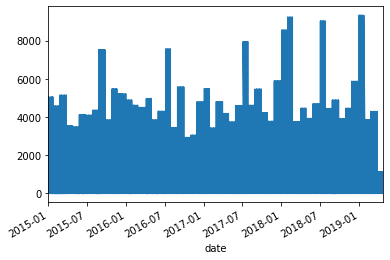

In [12]:
data['Sales'].plot()

In [14]:
data.loc[: ,'Sales']

date
2015-01-01    1403.50
2015-01-08    1403.50
2015-01-15    1403.50
2015-01-22    1403.50
2015-01-29    1829.75
               ...   
2019-03-28    3230.60
2019-04-04     277.25
2019-04-11     277.25
2019-04-18     277.25
2019-04-25     277.25
Name: Sales, Length: 10848, dtype: float64

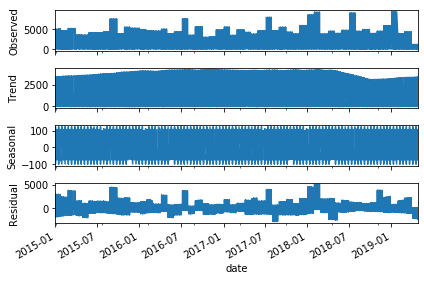

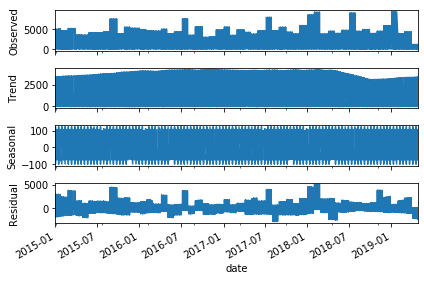

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(data.loc[: ,'Sales'], model = 'add', freq=100)
a.plot()

In [92]:
len(SKU_Customer_list)

48

In [45]:
# data[['Sales', 'SKU_Customer']]
SKU_Customer_list = data['SKU_Customer'].unique()

In [ ]:
period = 26
previous_df = pd.DataFrame()

for i in SKU_Customer_list:
    model = auto_arima(data[data.SKU_Customer == i].Sales, 
                         start_p = 1,
                         start_q = 1,
                         max_p = 3,
                         max_q = 3,
                         m=12,
                         start_P = 0,
                         seasonal = True,
                         d =1,
                         D = 1,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
    
    model.fit(data[data.SKU_Customer == i].Sales)

    future_forecast = model.predict(n_periods = period)
    last_df = pd.DataFrame({'SKU_Customer': i*period,
                          'prediction': future_forecast})
    
    previous_df = pd.concat([previous_df, last_df], ignore_index = True)  

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2883.868, BIC=2900.674, Fit time=2.342 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2990.822, BIC=2997.545, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2933.833, BIC=2947.278, Fit time=1.473 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2881.764, BIC=2895.209, Fit time=3.085 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2883.644, BIC=2900.450, Fit time=4.864 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2987.425, BIC=2997.509, Fit time=0.665 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=2883.636, BIC=2900.442, Fit time=8.518 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2885.279, BIC=2905.447, Fit time=18.210 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=2879.868, BIC=2889.952, Fit time=1.616 seconds
Fit ARIMA: order=(0, 1, 0) 

### Holt winter: